## Axicon transformation
In this notebook: transform of plane wave and Gaussian beam by an axicon using Fourier decomposition.

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,ifft,fft2,ifft2,fftshift,ifftshift
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from matplotlib import colors
from time import time
import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

In [2]:
## physics and system params. all units in m
lmbda = 1.064
k = 2*pi/lmbda
f = 1e5 # lens focal length
a = 100 # the aperture radius
delta = 20*pi/180

## grid params
w = 2*a # grid half-width
pts = 1001 #1025
x0pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)
# print('rr.shape =', rr.shape)
phase = k*tan(delta)*rr % 2*pi
mask = circ_mask(rr, a)*exp(-1j*phase)
# mask.shape

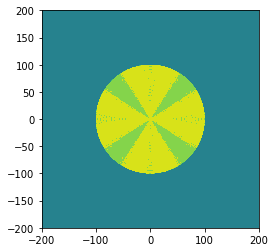

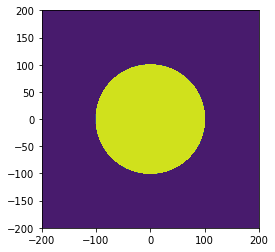

In [3]:
fig, ax = figax()
ax.contourf(x0pts, x0pts, imag(mask))
plt.show()
fig, ax = figax()
ax.contourf(x0pts, x0pts, abs(mask))
plt.show()

In [4]:
## compute output field with Fresnel diffraction

padding = int(pts-1/2)
field0 = zero_pad(mask, padding)
rr = zero_pad(rr, padding)

field1 = fftshift(fft2(ifftshift(field0)))

field1 = unpad(field1, padding)
rr = unpad(rr, padding)

I1 = conjugate(field1)*field1
I1 /= amax(I1)
I1x = justify(I1[midpt,:])

In [5]:
## compute output field with Fourier propagation

field0 = mask

# define k space grid and field
dfx = 1/(x0pts[-1] - x0pts[0])
fx_list = range(-(pts-1)//2,(pts-1)//2+1,1)*dfx
kx_list = 2*pi*fx_list
ky_list = -kx_list
KX, KY = meshgrid(kx_list, ky_list)
KZ_real = real(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ_imag = imag(sqrt(k**2 - KX**2 - KY**2 + 0j))
KZ = KZ_real + 1j*abs(KZ_imag)
field0_kspace = fftshift(fft2(field0))

# propagate
phase = f*KZ_real % 2*pi
field1_kspace = field0_kspace*exp(1j*f*KZ)

# transform back to real space
field1 = ifft2(field1_kspace)

I1_FD = conjugate(field1)*field1
I1_FD /= amax(I1_FD)
# I1x_FD = justify(I1_FD[midpt,:])

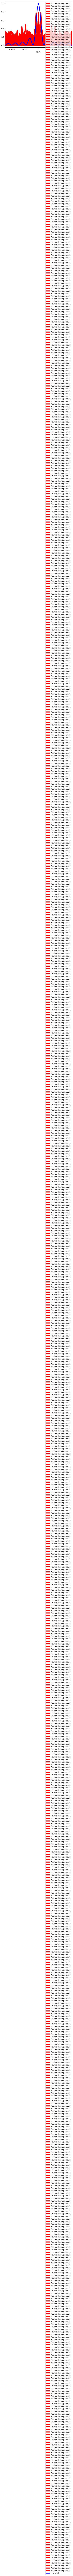

In [7]:
## plot a slice of the field in the Fourier plane

plt.close()
fig,ax = plt.subplots(figsize=(7,5))
fig.dpi=100

x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f/(2*padding+pts) for i in linspace(-pts/2, pts/2, pts)])

start = 400
stop = len(x1pts) - start

# the analytic result, up to constant scaling factor
# I1_func = lambda x: (j1(a*x*k/f)/x)**2
# x1_pts = linspace(x1pts[start],x1pts[stop],200) # essentially the same as x1pts but omits x=0
# I1_analytic = I1_func(x1_pts)
# I1_analytic /= max(I1_analytic)

# plot the fourier decomp result
ax.plot(x1pts[start:stop], real(I1_FD)[start:stop], label='Fourier decomp. result',color='red',linewidth=6)

# plot the fft result
ax.plot(x1pts[start:stop], real(I1x)[start:stop], label='FFT result',color='blue',linewidth=4)

# ax.plot(x1_pts, I1_analytic, label='analytic result', color='orange')
# # ax.set_title('Circular apperture diffraction intensity')

ax.set_xlabel(r'x [um]')
ax.set_xlim(-2500,2500)

ax.legend(loc='upper right')